<a href="https://colab.research.google.com/github/LucasVD23/CNN_With_Data_Augmentation/blob/main/T2_AM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Trabalho 2 de Aprendizado de Máquina 2**

Grupo: 
  
  *Lucas Vinícius Domingues 769699*

  *Rafael Yoshio Yamawaki Murata 769681*

  *Victor Luís Aguilar Antunes 769734*

**Avaliação de técnincas de Data Augmentation para CNN no reconhecimento de raças de cachorro por meio de imagens**

Dataset Utilizado:

https://www.kaggle.com/datasets/abhinavkrjha/dog-breed-classification?resource=download

#### Importações

In [ ]:
!pip install imgaug

In [2]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.utils import shuffle
import cv2, os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Funções auxiliares

In [2]:
from keras.applications.vgg19 import VGG19

#Definição do modelo a ser usado
def build_model_VGG():
    #Uso de parte da arquitetura VGG
    model = VGG19(input_shape=(142,225,3), include_top=False)
    #Somente as duas últimas camadas são treináveis
    for layer in model.layers[:-2]:
        layer.trainable = False
    #definção das camadas 2 camadas densas finais
    out_layers = Flatten()(model.layers[-1].output)

    out_layers = Dense(1024, activation='relu')(out_layers)
    out_layers = Dropout(0.33)(out_layers)

    out_layers = Dense(256, activation='relu')(out_layers)
    out_layers = Dropout(0.33)(out_layers)

    out_layers = Dense(14, activation='softmax')(out_layers)

    model = keras.Model(inputs=model.inputs, outputs=out_layers)

    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


    return model

In [3]:
def plot_history(history):

    plt.subplot(2,1,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='lower left')
    plt.show()

    plt.subplot(2,1,2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('epoch')
    plt.legend(['acc', 'val_acc'], loc='upper left')
    plt.show()

In [4]:
def print_eval(test_images, test_labels,model):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(test_loss)
    print(test_acc)
    return(test_loss,test_acc)

### Leitura

In [3]:
from google.colab import drive
path = '/content/dogs/'
#Leitura das imagens
imgs = []
labels =[]
min_x = 9999
min_y = 9999
#leitura de dados, os nomes das pastas contem os nomes das raças
#cada possui como label a raça que consta no nome pasta ao qual pertence
for breed in os.listdir(path):
    folder = path+'/'+breed
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        img = cv2.imread(f)
        if(not(img is None)):
            imgs.append(img)
            labels.append(breed.split(' ')[0])
            if(img.shape[0] <min_x):
                min_x = img.shape[0]
            if(img.shape[1] <min_y):
                min_y = img.shape[1]     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Resize para a resolução mínima, para que não hajam distorções
for i in range(0,len(imgs)):
  imgs[i] = cv2.resize(imgs[i],(min_x,min_y))

print(imgs[0].shape)  
imgs = np.array(imgs)
labels = np.array(labels)

labels =  np.reshape(labels,(labels.shape[0],1)) 

(142, 225, 3)


In [5]:
np.unique(labels), len(np.unique(labels))

(array(['Affenhuahua', 'Afgan', 'Akita', 'Alaskan', 'American', 'Auggie',
        'Beagle', 'Belgian', 'Bichon', 'Bocker', 'Borzoi', 'Boxer', 'Bugg',
        'Bulldog'], dtype='<U11'), 14)

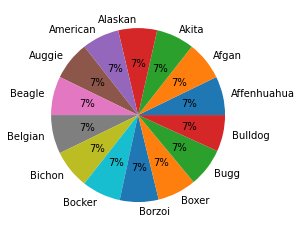

In [6]:
#Proporção das classes
data, count = np.unique(labels, return_counts = True)
plt.figure(figsize=(4,4))
plt.pie(count, labels = data, autopct='%1.0f%%')
plt.show()

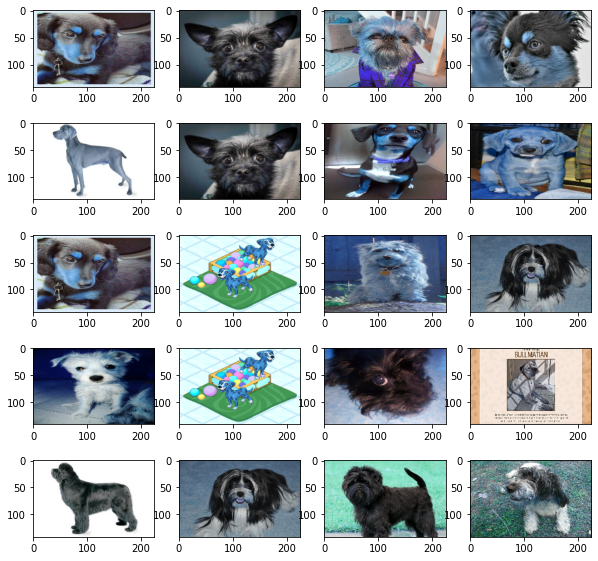

In [7]:
# Visualizando parte da amostra
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(imgs[i])
    plt.grid(False)  

### Pré-processamento

In [11]:
# Normalização dos pixels
imgs = imgs/255

le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [13]:
# Separando em conjunto de testes e treino
X_train,X_test,y_train,y_test = train_test_split(imgs,labels,test_size = 0.2,
                                                 random_state = 0)

y_train = np.reshape(y_train,(y_train.shape[0],1))
y_test =  np.reshape(y_test,(y_test.shape[0],1))

### Modelo Inicial

In [14]:
model  = build_model_VGG()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 142, 225, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 142, 225, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 142, 225, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 71, 112, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 71, 112, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 71, 112, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 56, 128)       0     

In [15]:
#Uso de callbacks Reduce Learning Rate on Plateu e EarlyStopping
meus_callbacks = [
        keras.callbacks.EarlyStopping(patience=5),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                          patience=5, min_lr=0.0001), 
]
tf.random.set_seed(42)
#treino com 20% do conjunto passado sendo usado para validação
history = model.fit(X_train, y_train,
                    epochs = 50, validation_split=0.2,callbacks=meus_callbacks)

Epoch 1/50
14/14 [==============================] - 18s 700ms/step - loss: 3.2025 - accuracy: 0.1216 - val_loss: 2.4080 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 323ms/step - loss: 1.7721 - accuracy: 0.4865 - val_loss: 1.7719 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 321ms/step - loss: 0.9259 - accuracy: 0.7252 - val_loss: 1.3047 - val_accuracy: 0.6216 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 321ms/step - loss: 0.4744 - accuracy: 0.8874 - val_loss: 1.3495 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 322ms/step - loss: 0.2390 - accuracy: 0.9414 - val_loss: 1.0762 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 322ms/step - loss: 0.1841 - accuracy: 0.9640 - val_loss: 1.2387 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 4s 319ms/step - l

In [16]:
#arrays a serem usados na comparação de múltiplos do data augmentation
losses = []
accuracys = []

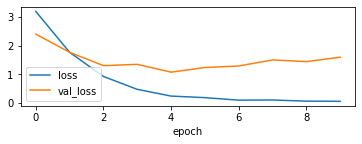

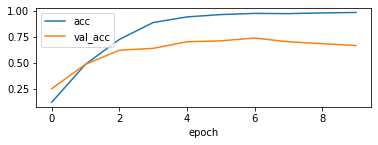

5/5 [==============================] - 3s 599ms/step - loss: 1.9023 - accuracy: 0.6475
1.9023150205612183
0.6474820375442505


In [17]:
plot_history(history)
loss,acc = print_eval(X_test, y_test, model)
losses.append(loss)
accuracys.append(acc)

In [18]:
predictions = model.predict(X_test)
predictions

array([[2.8848651e-06, 9.9986410e-01, 4.0676539e-07, ..., 1.2779840e-05,
        3.3342101e-05, 3.7994263e-07],
       [6.3532803e-05, 4.0954671e-08, 1.8473545e-06, ..., 8.3275603e-07,
        7.2110247e-06, 1.1736128e-08],
       [2.1719825e-05, 2.6210243e-04, 3.3278695e-05, ..., 1.9108433e-05,
        1.7436441e-04, 2.2949864e-06],
       ...,
       [2.2579147e-03, 1.1656127e-05, 2.9373223e-05, ..., 1.5505697e-05,
        9.8416752e-01, 3.0431484e-06],
       [5.5358805e-02, 2.1685998e-01, 1.9856321e-02, ..., 9.3905116e-03,
        4.5484257e-01, 1.8599360e-03],
       [1.9901547e-06, 1.4553821e-05, 8.6730433e-05, ..., 1.2398041e-04,
        1.2486024e-06, 1.6939724e-05]], dtype=float32)

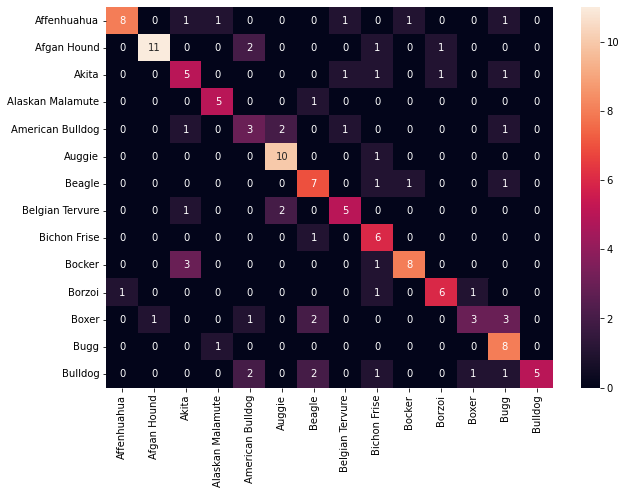

In [19]:
#Matriz de confusão das classes dos dataset
class_names = ['Affenhuahua','Afgan Hound','Akita','Alaskan Malamute',
               'American Bulldog','Auggie','Beagle','Belgian Tervure',
               'Bichon Frise','Bocker','Borzoi','Boxer','Bugg','Bulldog']
cm = confusion_matrix(y_test, predictions.argmax(1))
df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

# Data Augmentation


In [20]:
from imgaug import augmenters as iaa
seq = iaa.Sequential([
    iaa.Fliplr(0.3), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.2,
        iaa.GaussianBlur(sigma=(0, 0.25))
    ),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    
    iaa.Affine(
        scale={"x": (0.3, 0.7), "y": (0.3, 0.7)},
        translate_percent={"x": (-0.14, 0.14), "y": (-0.14, 0.14)},
        shear=(-3, 3)
    )
], random_order=True) # apply augmenters in random order

In [21]:
def test_augmentations(num_aug):
    #Separação para não haver data leakage na utilização de data augmentation
    X_train_aug,X_val,y_train_aug,y_val = train_test_split(
        X_train,y_train, test_size=0.2)

    y_train_aug = np.reshape(y_train_aug,(y_train_aug.shape[0],1))

    size = X_train_aug.shape[0]
    #dataset gerado possuirá tamanho t*(m+1) em que t é o tamanho do conjunto original e m múltiplo sendo testado
    #durante a execução desta função, m = num_aug
    #cada iteração adiciona o uma vez o número de imagens do dataset inicial ao novo dataset
    for i in range(0,num_aug):

        X_train_aug = np.vstack( (X_train_aug,
                                   seq.augment_images(X_train_aug[:size])) )
        y_train_aug = np.vstack( (y_train_aug,y_train_aug[:size]) )
    
    #plt.imshow(X_train_aug[0])
    #plt.show()
    #plt.imshow(X_train_aug[size])
    #plt.show()
    model = build_model_VGG(regularize = True)
    tf.random.set_seed(42)
    history = model.fit(X_train, y_train, epochs = 50, validation_split=0.2,
                        callbacks = meus_callbacks)
    
    print("Número de imagens: " + str(y_train_aug.shape[0]))
    plot_history(history)
    loss, acc = print_eval(X_test, y_test,model)
    return loss,acc

Epoch 1/50
14/14 [==============================] - 6s 347ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 319ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 323ms/step - loss: 1.0588 - accuracy: 0.6982 - val_loss: 1.3880 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 321ms/step - loss: 0.5038 - accuracy: 0.8649 - val_loss: 1.3640 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 318ms/step - loss: 0.2474 - accuracy: 0.9324 - val_loss: 1.4109 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 323ms/step - loss: 0.1776 - accuracy: 0.9595 - val_loss: 1.4535 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 4s 318ms/step - lo

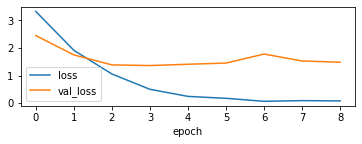

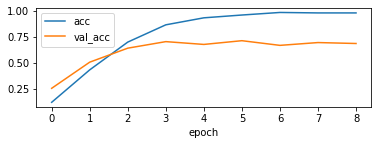

5/5 [==============================] - 1s 213ms/step - loss: 1.6097 - accuracy: 0.6978
1.6096930503845215
0.6978417038917542
Epoch 1/50
14/14 [==============================] - 6s 349ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 321ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 5s 333ms/step - loss: 1.0588 - accuracy: 0.6982 - val_loss: 1.3881 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 5s 336ms/step - loss: 0.5029 - accuracy: 0.8671 - val_loss: 1.3568 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 323ms/step - loss: 0.2413 - accuracy: 0.9347 - val_loss: 1.3939 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 0.1805 - accuracy: 0.9550 

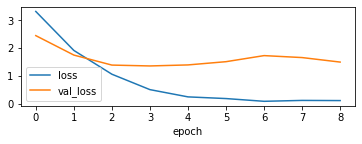

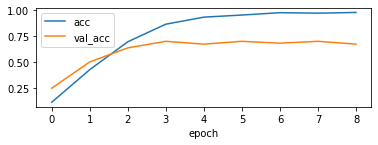

5/5 [==============================] - 1s 212ms/step - loss: 1.4520 - accuracy: 0.6906
1.4519556760787964
0.6906474828720093
Epoch 1/50
14/14 [==============================] - 6s 348ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 321ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 321ms/step - loss: 1.0588 - accuracy: 0.6982 - val_loss: 1.3881 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 319ms/step - loss: 0.5029 - accuracy: 0.8671 - val_loss: 1.3595 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 320ms/step - loss: 0.2409 - accuracy: 0.9347 - val_loss: 1.3888 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 324ms/step - loss: 0.1773 - accuracy: 0.9505 

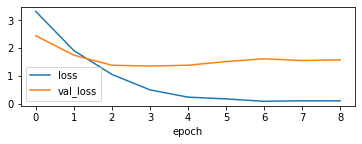

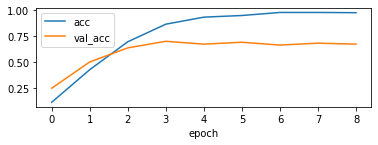

5/5 [==============================] - 1s 213ms/step - loss: 1.6157 - accuracy: 0.6547
1.6156995296478271
0.6546762585639954
Epoch 1/50
14/14 [==============================] - 6s 348ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 320ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 319ms/step - loss: 1.0575 - accuracy: 0.7005 - val_loss: 1.3841 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 321ms/step - loss: 0.4968 - accuracy: 0.8694 - val_loss: 1.3599 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 322ms/step - loss: 0.2463 - accuracy: 0.9189 - val_loss: 1.5308 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 321ms/step - loss: 0.2227 - accuracy: 0.9459 

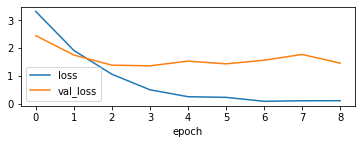

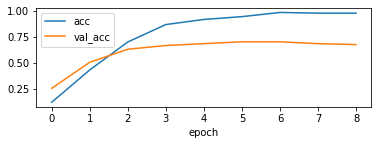

5/5 [==============================] - 1s 212ms/step - loss: 1.6489 - accuracy: 0.6691
1.6488845348358154
0.6690647602081299
Epoch 1/50
14/14 [==============================] - 6s 347ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 321ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 319ms/step - loss: 1.0586 - accuracy: 0.7027 - val_loss: 1.3798 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 321ms/step - loss: 0.4971 - accuracy: 0.8739 - val_loss: 1.3796 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 322ms/step - loss: 0.2492 - accuracy: 0.9234 - val_loss: 1.4002 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 0.2078 - accuracy: 0.9505 

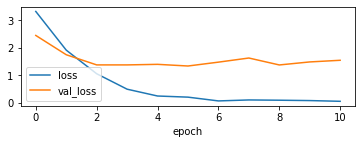

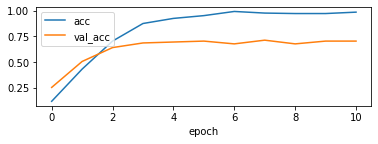

5/5 [==============================] - 1s 214ms/step - loss: 1.7473 - accuracy: 0.6691
1.747280240058899
0.6690647602081299
Epoch 1/50
14/14 [==============================] - 6s 347ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 321ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 323ms/step - loss: 1.0598 - accuracy: 0.6982 - val_loss: 1.3869 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 324ms/step - loss: 0.5023 - accuracy: 0.8649 - val_loss: 1.3506 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 321ms/step - loss: 0.2392 - accuracy: 0.9279 - val_loss: 1.4106 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 321ms/step - loss: 0.1825 - accuracy: 0.9640 -

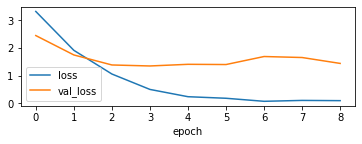

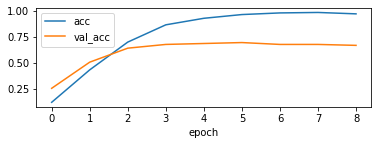

5/5 [==============================] - 1s 214ms/step - loss: 1.5657 - accuracy: 0.6691
1.5657297372817993
0.6690647602081299
Epoch 1/50
14/14 [==============================] - 6s 353ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 320ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 323ms/step - loss: 1.0588 - accuracy: 0.6982 - val_loss: 1.3880 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 324ms/step - loss: 0.5038 - accuracy: 0.8649 - val_loss: 1.3637 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 321ms/step - loss: 0.2479 - accuracy: 0.9324 - val_loss: 1.4251 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 0.1771 - accuracy: 0.9595 

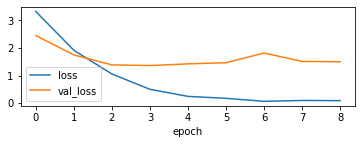

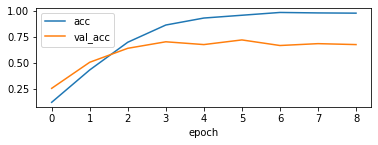

5/5 [==============================] - 1s 215ms/step - loss: 1.5382 - accuracy: 0.6978
1.538224220275879
0.6978417038917542
Epoch 1/50
14/14 [==============================] - 6s 351ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 322ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 324ms/step - loss: 1.0586 - accuracy: 0.7027 - val_loss: 1.3798 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 324ms/step - loss: 0.4981 - accuracy: 0.8761 - val_loss: 1.3809 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 323ms/step - loss: 0.2473 - accuracy: 0.9257 - val_loss: 1.3419 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 319ms/step - loss: 0.2135 - accuracy: 0.9459 -

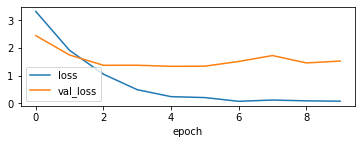

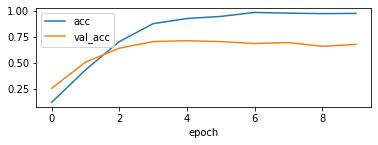

5/5 [==============================] - 1s 219ms/step - loss: 1.7988 - accuracy: 0.6547
1.7987855672836304
0.6546762585639954
Epoch 1/50
14/14 [==============================] - 6s 351ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 322ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 323ms/step - loss: 1.0586 - accuracy: 0.7027 - val_loss: 1.3798 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 324ms/step - loss: 0.4971 - accuracy: 0.8739 - val_loss: 1.3796 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 323ms/step - loss: 0.2488 - accuracy: 0.9234 - val_loss: 1.3976 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 0.2067 - accuracy: 0.9505 

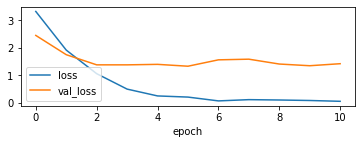

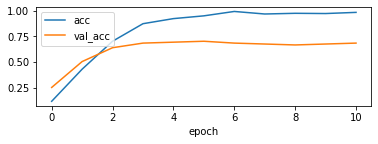

5/5 [==============================] - 1s 218ms/step - loss: 1.6723 - accuracy: 0.6835
1.6723456382751465
0.6834532618522644
Epoch 1/50
14/14 [==============================] - 6s 346ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 322ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 322ms/step - loss: 1.0564 - accuracy: 0.7005 - val_loss: 1.3794 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 322ms/step - loss: 0.4957 - accuracy: 0.8716 - val_loss: 1.3647 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 323ms/step - loss: 0.2451 - accuracy: 0.9212 - val_loss: 1.4382 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 321ms/step - loss: 0.2013 - accuracy: 0.9572 

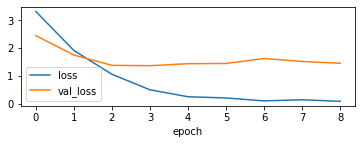

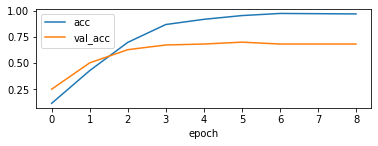

5/5 [==============================] - 1s 213ms/step - loss: 1.5704 - accuracy: 0.6906
1.5704288482666016
0.6906474828720093


In [22]:
#Iterações que verificam as acurácias do modelo treinado com t(m+1) imagens, em que m varia de 1 a 10
for i in range(1,11):
    loss, acc = test_augmentations(i)
    losses.append(loss)
    accuracys.append(acc)

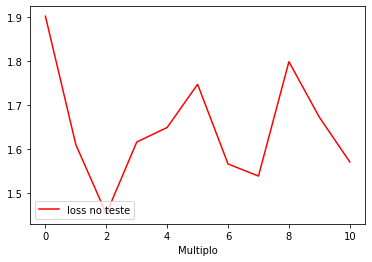

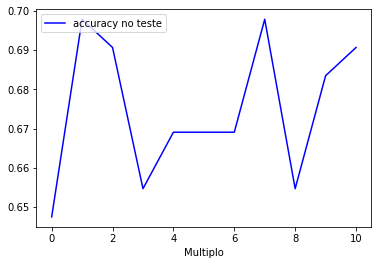

In [23]:
#Verificação de qual múltiplo m do conjunto de dados original fornceu a maior acurácia
plt.plot(losses,color = 'r')
plt.legend(["loss no teste"],loc = "lower left")
plt.xlabel("Multiplo")
plt.show()


plt.plot(accuracys,color='b')
plt.legend(["accuracy no teste"],loc = "upper left")
plt.xlabel("Multiplo")
plt.show()




Verificando modelo com melhor múltiplo

Epoch 1/50
14/14 [==============================] - 6s 355ms/step - loss: 3.3221 - accuracy: 0.1171 - val_loss: 2.4505 - val_accuracy: 0.2523 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 4s 322ms/step - loss: 1.9166 - accuracy: 0.4302 - val_loss: 1.7494 - val_accuracy: 0.5045 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 4s 322ms/step - loss: 1.0588 - accuracy: 0.6982 - val_loss: 1.3881 - val_accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 4s 321ms/step - loss: 0.5028 - accuracy: 0.8671 - val_loss: 1.3608 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 4s 320ms/step - loss: 0.2433 - accuracy: 0.9234 - val_loss: 1.3847 - val_accuracy: 0.6757 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 4s 320ms/step - loss: 0.1719 - accuracy: 0.9527 - val_loss: 1.5344 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 4s 321ms/step - lo

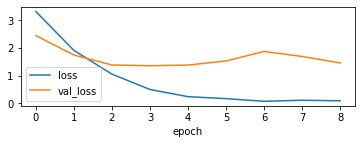

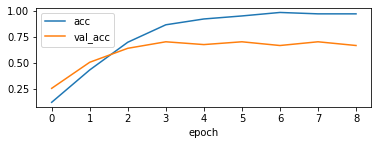

5/5 [==============================] - 1s 211ms/step - loss: 1.5097 - accuracy: 0.6835
1.5097180604934692
0.6834532618522644


In [25]:
_,_ = test_augmentations(1)

# Conclusão
Para os testes realizados neste trabalho, a utilização de Data Augmentation colaborou de maneira bastante limitada para o ganho de acurácia no modelo. Entretanto, os testes feitos aqui foram limitados pelos recursos de memória RAM disponibilizados pelo colab, sendo interessente o estudo da geração de múltiplos maiores do tamanho do dataset original, de preferência aliados a mais testes de diferentes combinações de efeitos a serem utilizados no processo de Data Augmentation.